# Проект "Предсказание отклика абонента на подключение услуги"
_Черненко А.Е._
# Создание модели

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install catboost

In [3]:
train_path = '/content/drive/My Drive/Colab Notebooks/megafon/data_f32_train.pkl'
test_path = '/content/drive/My Drive/Colab Notebooks/megafon/data_f32_test.pkl'

In [4]:
import pandas as pd
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt

from sklearn.compose import make_column_transformer
from sklearn.pipeline import FeatureUnion, make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc, confusion_matrix
from sklearn.linear_model import LogisticRegression

from catboost import CatBoostClassifier

Вспомогательные функции

In [5]:
def plot_roc_curve(fpr, tpr, model_name="", color=None):
    plt.plot(fpr, tpr, label='%s: ROC curve (area = %0.2f)' %
             (model_name, auc(fpr, tpr)), color=color)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0.0, 1.0, 0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('%s: Receiver operating characteristic curve' % model_name)
    plt.legend(loc="lower right")
    
def plot_precision_recall_curve(precision, recall, model_name="", color=None):
    plt.plot(recall, precision, label='%s: Precision-Recall curve (area = %0.2f)' %
             (model_name, auc(recall, precision)), color=color)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title("%s: Precision-Recall curve" % model_name)
    plt.axis([0.0, 1.0, 0.0, 1.05])
    plt.legend(loc="lower left")

# 1 EDA

In [6]:
# colab
train_data = pd.read_pickle(train_path)

# pc
#train_data = pd.read_pickle('data_f32_train.pkl')

In [7]:
train_data.head()

,id,vas_id,buy_time_vas,target,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,...,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,time_delta
0,540968.0,8.0,1.537132e+09,0.0,-31.559971,327.360901,-45.500786,274.753204,-50.918247,253.648209,49.15382,195.883896,-1.835267,-12.831245,-2.736081,56.284081,-2.558912,-66.189125,-77.518112,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-13.940815,54.495834,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,2.648138,0.785634,0.788392,-0.001884,-0.000023,-0.00003,62.580612,-0.065583,...,-9239.707031,-2.10805,-0.000083,-0.622896,-0.00004,-0.620772,-0.012257,-0.107878,969818880.0,-49.224079,-4.405604e+08,-120441800.0,-8.634002,-1.465191,-33.30238,810.871033,270.227509,-0.364694,-0.133771,-0.209468,269.643494,-109.884567,364.308990,41.631718,938.889282,-108.409744,-504.437317,-53.617977,-12.295406,-845.37384,-613.770813,-20.996269,-37.630447,-28.747725,4.167111,7.305572,-12.175933,21.543859,0.0,4838400.0
1,1454121.0,4.0,1.531688e+09,0.0,547.270020,238.430893,533.329224,274.803192,527.911743,253.698212,-16.08618,-65.076096,-6.783660,-30.006538,-2.736081,-4.007526,-2.558912,577.880859,566.551880,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-13.940815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.659389,-0.065583,...,-9239.707031,-2.10805,-0.000083,-0.622896,-0.00004,-0.620772,-0.012257,-0.107878,958586880.0,585.525940,1.072212e+09,-120441800.0,3.327904,-1.465191,-33.30238,-206.128983,-12.772491,-0.364694,-0.133771,-0.209468,-8.356505,-109.884567,-876.691040,-5.368281,-247.110703,-108.409744,-512.437317,-80.617981,-17.295406,-972.37384,-613.770813,-25.996269,-19.630449,-278.747711,-24.832888,-0.694429,-11.175933,-0.456140,0.0,604800.0
2,2458816.0,1.0,1.534108e+09,0.0,-92.139969,-95.469109,-106.080788,-139.596802,-111.498245,-142.901794,-16.08618,-65.076096,-6.783660,-30.006538,-2.736081,-4.007526,-2.558912,-66.189125,-74.978111,-0.000725,-0.016435,-0.107041,-5.41746,-1.058521,-13.940815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.659389,-0.065583,...,-9239.707031,-2.10805,-0.000083,0.377104,-0.00004,0.379228,-0.012257,-0.107878,-572669504.0,-58.544079,-4.405604e+08,-120441800.0,-6.314953,-1.465191,-33.30238,-266.128998,-39.772491,-0.364694,-0.133771,-0.209468,-35.356506,-109.884567,-703.691040,-5.368281,-247.110703,-108.409744,-339.437317,-106.617981,-17.295406,-977.37384,-613.770813,-25.996269,-37.630447,-304.747711,-25.832888,-0.694429,-12.175933,-0.456140,0.0,9072000.0
3,3535012.0,5.0,1.535922e+09,0.0,54.880028,12.970888,54.079212,-9.116798,48.661755,-30.221790,60.17382,87.453903,-6.783660,-30.006538,73.523918,-4.007526,-2.558912,-9.829127,-2.098110,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-0.800815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.659389,-0.065583,...,-9239.707031,-2.10805,-0.000083,1.377104,-0.00004,1.379228,-0.012257,-0.107878,-572669504.0,-58.544079,1.026649e+09,-120441800.0,-11.137705,-1.465191,-33.30238,-107.128983,-38.772491,-0.364694,-0.133771,0.790532,-35.356506,-109.884567,-574.691040,-5.368281,-244.110703,2.590259,-324.437317,-90.617981,-17.295406,-977.37384,-613.770813,-25.996269,-18.630449,-133.747726,-14.832889,-0.694429,-1.175933,-0.456140,0.0,2419200.0
4,1693214.0,1.0,1.535922e+09,0.0,45.160030,295.240875,64.679214,344.283203,59.261753,323.178223,-16.08618,-65.076096,-6.783660,-30.006538,-2.736081,-4.007526,-2.558912,-66.189125,58.081890,-0.000725,-0.016435,-0.107041,-5.41746,3.181479,19.519184,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.659389,-0.0

## __Признаки:__
* `buy_time_vas` - временной штамп отклика клиента на услугу;
* `time_delta` - временной интервал в секундах, разница между временным штампом отклика клиента на услугу и временным штампом записи о профиле потребления клиента, по смыслу может отражать актуальность данных профиля потребления на момент отклика клиента на улсугу;
* `id` - индивидуальный номер клиента;
* `vas_id` - вид услуги;
* 253 анонимизированных признака, отражающих профиль потребления клиента.

Рассмотрим их подробнее.

### `buy_time_vas`:

In [8]:
date = pd.to_datetime(train_data['buy_time_vas'], unit='s').dt.tz_localize('UTC').dt.tz_convert('Europe/Moscow')
date.sample(5)

729579   2018-09-03 00:00:48+03:00
792320   2018-11-26 00:00:48+03:00
560279   2018-07-23 00:00:48+03:00
541471   2018-10-22 00:00:48+03:00
777957   2018-09-10 00:00:48+03:00
Name: buy_time_vas, dtype: datetime64[ns, Europe/Moscow]

Присутствует только информация по дате.
Рассмотрим количество уникальных составляющих даты по всему признаку:

In [9]:
date_features = pd.DataFrame()
date_features['month'] = date.dt.month
date_features['day'] = date.dt.day
date_features['dayofyear'] = date.dt.dayofyear
date_features['dayofweek'] = date.dt.dayofweek
date_features['weekofyear'] = date.dt.weekofyear
date_features.nunique()

month          6
day           22
dayofyear     26
dayofweek      1
weekofyear    26
dtype: int64

* Имеются наблюдения за 6 месяцев. 
* Все наблюдения относятся к одному дню недели, соответственно, данные `day`, `dayofyear` не несут никакой полезной информации.
* Признаки `month` и `weekofyear` по логике сильно коррелированы.

Рассмотрим влияние номера недели в году на относительную частоту положительного отклика клиентов на услугу.

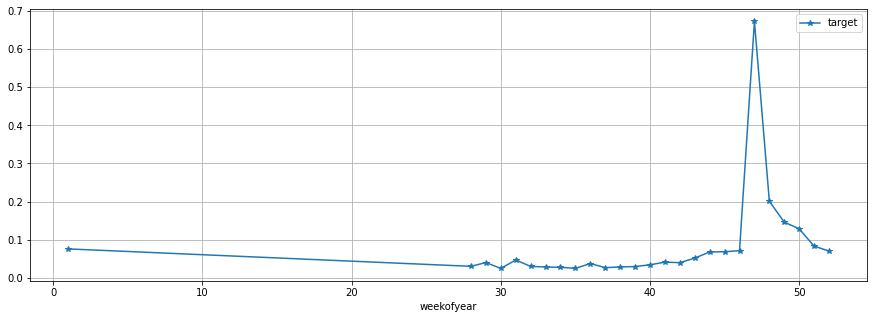

In [10]:
week_target = pd.concat([train_data['target'], date, date_features['weekofyear']], axis=1).sort_values('buy_time_vas')
week_target.groupby('weekofyear').mean().plot(style='-*', figsize=(15,5), grid=True)
plt.show()

Наблюдения `weekofyear`, имеющие значение 1, на самом деле относятся к самому концу года. Дело в том, что это дата 31 декабря 2018 года. И это понедельник - поэтому алгоритм определяет эту дату как первую неделю 2019 года. Но это не имеет значения. 

На графике наблюдается аномальный скачок частоты положительных откликов на 47 неделе. Это 19-25 ноября 2018 г., обычная рабочая неделя. Возможно, данная аномалия может объясняться запуском в этот период особых маркетинговых акций или рекламных кампаний, так как рост скачка резкий, а спад чуть медленнее, инертнее. В любом случае, такие аномалии будут только ухудшать модель, поэтому __не будем использовать временные данные `buy_time_vas` в обучении__.

### `time_delta`:
Значения в секундах. Трансформируем данный признак в диапазоне значений от 0 до 1 и применим экспоненту от отрицательного значения. Чем больше временная разница, тем меньше вес. В конце проверим значения на пропуски.

In [11]:
w_sc = StandardScaler().fit_transform(train_data['time_delta'].values.reshape(-1,1))
w = 1 / (1 + np.exp(w_sc))

assert not np.isnan(w).any()

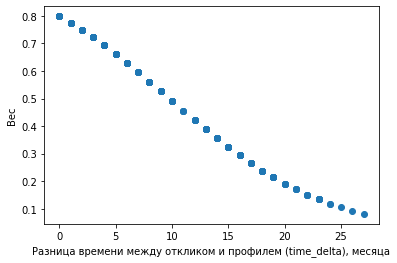

In [12]:
plt.scatter(train_data['time_delta'].values.reshape(-1,1)[:200]/(60*60*24*7),w[:200])
plt.xlabel('Разница времени между откликом и профилем (time_delta), месяца')
plt.ylabel('Вес')
plt.show()

In [13]:
train_data['time_delta'] = w

### `id`:
Использование id в модели нецелесообразно. id - уникальный идентификатор клиента: как число исползовать нельзя, а как категорию практически невозможно, так как появляются новые клиенты. Поэтому id не будем использовать в обучающей выборке.

### `target`:
Целевая переменная, определяет отклик клиента на услугу.
* 0 - клиент отказался от услуги
* 1 - клиент подключил услугу

Рассмотрим распределение переменной в обучающей выборке:

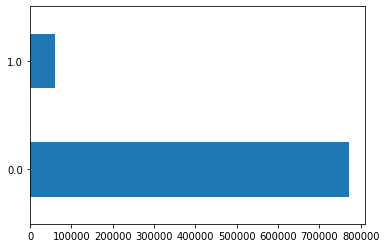

In [14]:
train_data['target'].value_counts().plot(kind='barh')
plt.show()

Наблюдается сильная несбалансированность классов. Это необходимо будет учесть при построении моделей.

### `vas_id`:
Идентификатор услуги. Рассмотрим распределение признака.

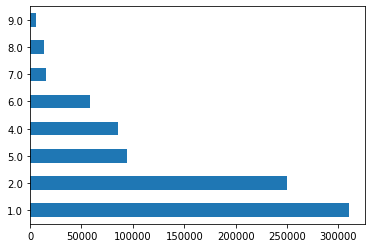

In [15]:
train_data['vas_id'].value_counts().plot(kind='barh')
plt.show()

Будем использовать этот признак в качестве категориального.

Остальные признаки сложно разведать, поэтому будем применять селекцию признаков, но сначала отделим от обучающих данных целевую переменную и определимся с типами признаков.

In [16]:
X = train_data.drop(['id','target','buy_time_vas'], axis=1)
y = train_data['target']

# 2 Определение типов признаков

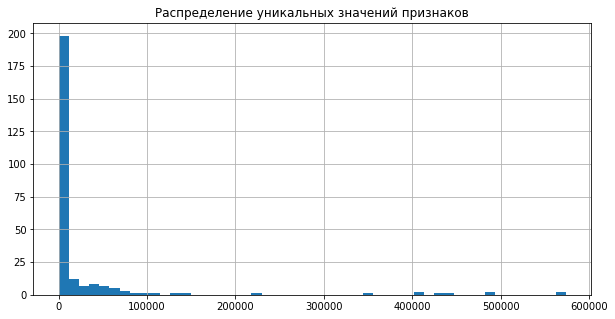

In [17]:
X_nunique = X.apply(lambda x: x.nunique(dropna=False))
plt.title("Распределение уникальных значений признаков");
X_nunique.hist(bins=50, figsize=(10, 5));

#### Всего признаков

In [18]:
f_all = set(X_nunique.index.tolist())
len(f_all)

255

#### Константные признаки

In [19]:
f_const = set(X_nunique[X_nunique == 1].index.tolist())
len(f_const)

5

#### Числовые признаки

In [20]:
f_numeric = (X.fillna(0).astype(int).sum() - X.fillna(0).sum()).abs()
f_numeric = set(f_numeric[f_numeric > 0].index.tolist())
len(f_numeric)

248

#### Категорийные признаки

In [21]:
f_other = f_all - (f_numeric | f_const )
f_categorical = set(X_nunique.loc[f_other][X_nunique.loc[f_other] <= 10].index.tolist())
f_categorical

{'vas_id'}

Прочие признаки

In [22]:
f_other = f_other - f_categorical
f_other

{'252'}

Рассмотрим признак `'252'`.

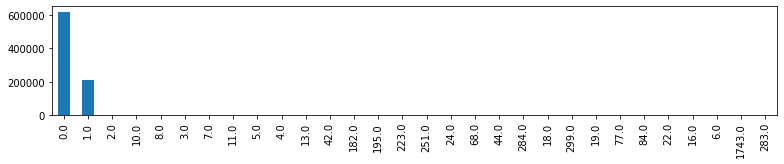

In [23]:
train_data['252'].value_counts().plot(kind='bar',figsize=(13,2))
plt.show()

Видно, что признак 252 практически бинарный. Удалим (=nan) все значения, кроме 0 и 1.

In [24]:
X.loc[X['252']>1,:] = X['252'].value_counts().argmax()

In [25]:
f_categorical = f_categorical | {'252'}
f_other = f_other - {'252'}
len(f_other)

0

Признак time_delta обозначим как весовой тип.

In [26]:
f_weight = {'time_delta'}
f_numeric = (f_numeric | f_other ) - f_weight

Проверка: не осталось ли пропущенных стобцов

In [27]:
assert(X_nunique.shape[0] == len(f_const) + len(f_numeric) + len(f_categorical) + len(f_weight))

#### Итог

In [28]:
print('f_all:', X.shape[1])
print()
print('f_const:', len(f_const))
print('f_categorical:', len(f_categorical))
print('f_numeric:', len(f_numeric))
print('f_weght:', len(f_weight))


f_ok = list(f_categorical | f_numeric | f_weight)
f_categorical, f_numeric, f_weight = list(f_categorical), list(f_numeric), list(f_weight)

f_all: 255

f_const: 5
f_categorical: 2
f_numeric: 247
f_weght: 1


# 3 Логистическая регрессия
### 3.1 Пайплайн для предобработки данных
Логистическая регрессия требует отмасштабированные числовые признаки и перекодированные в числовые категориальные признаки. 

In [29]:
# пайплайн для числовых признаков
f_num_pipepline = make_pipeline(
    SimpleImputer(strategy="mean"),
    StandardScaler()
)

# пайплайн для категориальных признаков
f_cat_pipepline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown='ignore')
)

# объединяющий пайплайн
preproc_pipeline = make_column_transformer(
    (f_num_pipepline, f_numeric),
    (f_cat_pipepline, f_categorical)
)

## 3.2 Поиск и обучение модели с применением пайплайнов

Схема пайплайна:

__|Предобработка данных| >>> |Селекция признаков| >>> |Модель логистической регрессии|__

Селектор признаков - `SelectPercentile()` с установкой `score_func=f_classif`. Данный селектор отбирает задаваемый процент лучших признаков, а оценочная функция `f_classif`предназначена для задач классификации.

Модель логистической регрессии с автоматической балансировкой классов `class_weight='balanced'`.

In [30]:
logreg_pp = Pipeline([
    ('prepoc', preproc_pipeline),
    ('selector', SelectPercentile()),
    ('model', LogisticRegression(n_jobs=-1,
                                 random_state=42,
                                 class_weight='balanced',
                                 max_iter=200))
])

#### Разделение на тренировочную, валидационную выборки и веса

In [31]:
X_train, X_valid, y_train, y_valid = train_test_split(X[f_ok], y, test_size=0.33, random_state=42)

columns_data = X_train.columns.drop(f_weight)

X_train_weight = X_train[f_weight].values.flatten()
X_valid_weight = X_valid[f_weight].values.flatten()

X_train = X_train.drop(f_weight, axis=1)
X_valid = X_valid.drop(f_weight, axis=1)

#### Cетка гиперпараметров

In [32]:
params = {
    'selector__percentile': [10, 30],
    'model__C': [0.1, 1, 10, 100]   
}

#### Поиск наилучшей модели по сетке гиперпараметров с использованием кросс-валидации

In [33]:
logreg_model = GridSearchCV(estimator=logreg_pp,
                            param_grid=params,
                            cv=3,
                            scoring='roc_auc',
                            n_jobs=-1,
                            verbose=1,
                            refit=True)

In [34]:
%%time

_ = logreg_model.fit(X_train, y_train, model__sample_weight=X_train_weight)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  4.1min finished


CPU times: user 6.79 s, sys: 2.92 s, total: 9.71 s
Wall time: 4min 30s


#### Параметры наилучшей модели

In [35]:
pd.Series(logreg_model.best_params_)

model__C                100
selector__percentile     10
dtype: int64

#### Предсказание на валидационной выборке
* вероятность класса 1
* метки

In [36]:
logreg_proba_1 = logreg_model.predict_proba(X_valid)[:,1]
logreg_pred = logreg_model.predict(X_valid)

## 3.3 Анализ результатов предсказания

### ROC-кривая

LogisticRegression: AUC_ROC = 0.847


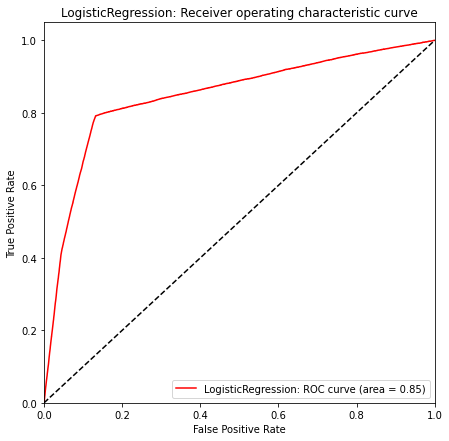

In [37]:
fpr, tpr, _ = roc_curve(y_valid, logreg_proba_1)
plt.figure(figsize=(7, 7))
plot_roc_curve(fpr, tpr, "LogisticRegression", color='r')
print("LogisticRegression: AUC_ROC = %.3f" % auc(fpr, tpr))

Достаточно хороший показатель метркии ROC AUC

### Precision-Recall-кривая

LogisticRegression: AUC_PR = 0.343


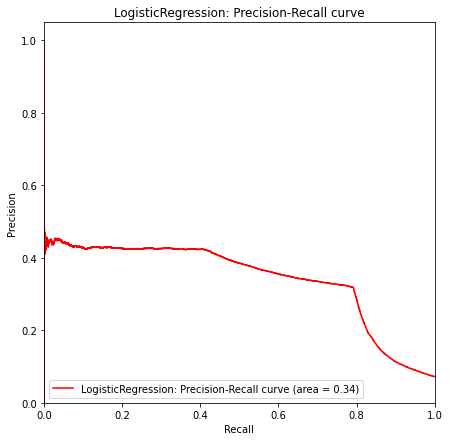

In [38]:
precision, recall, _ = precision_recall_curve(y_valid, logreg_proba_1)

plt.figure(figsize=(7, 7))    
plot_precision_recall_curve(precision, recall, "LogisticRegression", color='r')
print("LogisticRegression: AUC_PR = %.3f" % auc(recall, precision))

По графику видно, что значения точности выше ~0.4 достигнуть нельзя, но при этом почти не теряя точности можно добиться полноты до 0.8.

### Сonfusion matrix и практиекое применение результата

In [39]:
print(confusion_matrix(y_valid,logreg_pred))

[[221015  33612]
 [  4126  15693]]


Матрица смежности показывает 
* в  левом верхнем углу количество истинных предсказаний класса 0
* в правом верхнем углу количество  ложных  предсказаний класса 1 (ошибка второго рода)
* в  левом нижнем  углу количество  ложных  предсказаний класса 0 (ошибка первого рода)
* в правом нижнем  углу количество истинных  предсказаний класса 1

Если принять за нулевую гипотезу - положительный отклик клиента на услугу (класс 1), и осуществлять клиентам рассылку  предложений по подключению услуги согласно предсказаниям модели, то 
* количество ошибок первого рода характеризует сколько клиентов не получили предложения, хотя потенцаильно они готовы совершить подключение;
* количество ошибок второго рода характеризует сколько клиентов получили предложения, хотя они не собираются совершать подключение.
 
При построении стратегии рассылки предложений необходимо учитывать, что 

Прибыль оператора от положительного отклика клиента на услугу равна разнице между Доходом от клиента и Затратами на рассылку предложения этому клиенту.

$$Прибыль = Доход - Затраты$$

Таким образом, ошибка первого рода будет отражать какой Доход оператор потерял не отправив предложение. А ошибка второго рода - какие Затраты оператора на рассылку оказались напрасными.

Итого реальная прибыль от кампании по рассылке предложений будет определяться формулой:

$$REAL = N_+ \cdot (Доход - Затрата) - N_{e2} \cdot Затрата$$,

а упущенная прибыль

$$N_{e1} \cdot (Доход - Затрата)$$,

максимально возможная прибыль определяется формулой:

$$MAX = (N_+ + N_{e1}) \cdot (Доход - Затрата)$$

где $N_+$ - количество положительных откликов на отправленное предложение

$N_{e1}$ - количество упущенных клиентов, готовых подключить услугу (ош. 1 рода)

$N_{e2}$ - количество напрастно отправленных предложений (ош. 2 рода)

Для получения максимальной выгоды необходимо минимизировать разницу $MAX - REAL$, то есть упрощая выражение

$$\frac{Доход - Затраты}{Затраты} \cdot N_{e1} + N_{e2} \rightarrow min$$

Так как Доход от подключения услуги, как правило, на несколько порядков превышает Затрату на рассылку предложения (например, услуга со стоимостью подключения 100 р., затрата на смс-рассылку 10 коп.), то $N_{e1}$ гораздо сильнее влияет, чем $N_{e2}$, на изменение выгоды. Максимально возможная выгода достигается лишь, когда $N_{e1}=N_{e2}=0$, то есть оператор абсолютно безошибочно разослал все предложения. Это практически невозможно и является идеальным случаем.

Построим график количества ошибок 1 и 2 рода при разных порогах на предсказаниях нашей модели. Используя последнюю формулу и задавая конкретные значения Дохода `income` от услуги и Затрат `expense` на предложение найдем порог, при котором мы добъемся максимальной выгоды

In [40]:
def plot_fp_fn_curve(y_true, y_pred_proba, threshold, income_expense):
    
    plt.figure(figsize=(10, 5))  
    
    fp_fn_thr = list()
    for thr in threshold:
        y_pred = np.ones(y_pred_proba.shape)
        y_pred[y_pred_proba<thr] = 0
        fp, fn = confusion_matrix(y_true, y_pred).ravel()[1:3]
        fp_fn_thr.append([fp, fn, thr])
        
    vectors = np.array(fp_fn_thr)[:,0:2]
    thresholds = np.array(fp_fn_thr)[:,2]
    plt.plot(vectors[:,0], vectors[:,1], c='black', label='model FP-FN-curve', alpha=0.5)
    
    for income, expense in income_expense:
        coef = income / expense - 1
        ie_vectors = vectors.copy()
        ie_vectors[:,1] = ie_vectors[:,1] * coef        
        norms = np.linalg.norm(ie_vectors, axis=1)
        min_idx = np.where(norms == np.amin(norms))
        plt.scatter(vectors[min_idx,0],
                    vectors[min_idx,1],                   
                    label=f'income:{income}, expense:{expense}, threshold:{thresholds[min_idx][0]:.2f}')
    
    plt.legend(loc="upper right")
    plt.xlabel('False Positive')
    plt.ylabel('False Negative')
    plt.show()     

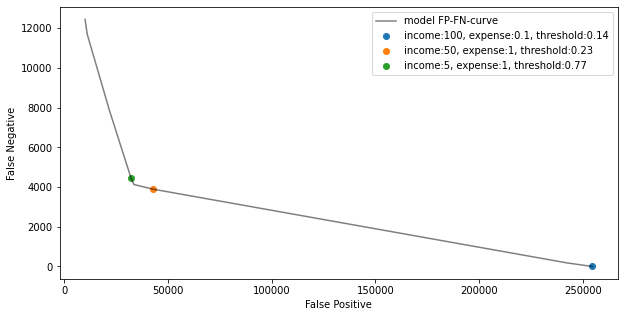

In [41]:
income_expense = [[100, 0.1],
                  [50, 1],
                  [5, 1]]

plot_fp_fn_curve(y_valid, logreg_proba_1, np.linspace(0.1,0.9,20), income_expense)

* доход 100 р., затраты 10 коп. - наиболее оптимальный порог для предсказаний с максимальной выгодой - 0.14
* доход 50 р., затраты 1 руб. - наиболее оптимальный порог для предсказаний с максимальной выгодой - 0.23
* доход 5 р., затраты 1 руб. - наиболее оптимальный порог для предсказаний с максимальной выгодой - 0.77

# 4 Библиотека Catboost

### 4.1 Предобработка данных
Catboost не требует масштабировать числовые признаки и кодировать категориальные. 

In [42]:
selector = SelectPercentile()
X_cat = selector.fit_transform(X[f_ok], y)
columns = X[f_ok].columns
support = selector.get_support()
selected_columns = columns[support]

for feat in f_categorical+f_weight:
    assert feat in selected_columns

X_cat = pd.DataFrame(X_cat, columns=selected_columns)

X_cat[f_categorical] = X_cat[f_categorical].astype('int').astype('category')

In [43]:
X_train_cat, X_valid_cat, y_train_cat, y_valid_cat = train_test_split(X_cat, y, test_size=0.33, random_state=42)

### 4.2 Модель CatBoostClassifier
* Функция потерь: Logloss
* Автобалансировка классов

In [44]:
cat_model = CatBoostClassifier(loss_function='Logloss',
                               random_seed = 42,
                               auto_class_weights='Balanced',
                               task_type='GPU',
                               logging_level='Verbose',
                               cat_features=f_categorical,
                               od_type='IncToDec')

#### Сетка гиперпараметров
* количество деревьев
* скорость обучения
* глубина дерева
* регуляризация

In [45]:
grid = {
    'n_estimators' : [100, 200, 500],
    'learning_rate': [0.1, 0.5, 1],
    'depth': [2, 3, 6, 8],
    'l2_leaf_reg': [1, 5, 10, 20]
}

#### Рандомизированный поиск по сетке с применением кросс-валидации
Случайным образом по сетке параметров выбирается и проверяется 30 наборов гиперпараметров.

In [46]:
search_result = cat_model.randomized_search(grid,
                                            X=X_train_cat,
                                            y=y_train_cat,
                                            cv=3,
                                            stratified=True,
                                            search_by_train_test_split=False,
                                            n_iter=30)

0:	loss: 0.4444949	best: 0.4444949 (0)	total: 25.6s	remaining: 12m 22s
1:	loss: 0.4447084	best: 0.4444949 (0)	total: 1m 26s	remaining: 20m 9s
2:	loss: 0.4443586	best: 0.4443586 (2)	total: 2m 27s	remaining: 22m 9s
3:	loss: 0.4443253	best: 0.4443253 (3)	total: 3m 29s	remaining: 22m 39s
4:	loss: 0.4447055	best: 0.4443253 (3)	total: 4m 31s	remaining: 22m 37s
5:	loss: 0.4447278	best: 0.4443253 (3)	total: 4m 46s	remaining: 19m 4s
6:	loss: 0.4442212	best: 0.4442212 (6)	total: 5m	remaining: 16m 27s
7:	loss: 0.4441364	best: 0.4441364 (7)	total: 5m 15s	remaining: 14m 26s
8:	loss: 0.4440505	best: 0.4440505 (8)	total: 5m 43s	remaining: 13m 20s
9:	loss: 0.4440463	best: 0.4440463 (9)	total: 6m 10s	remaining: 12m 20s
10:	loss: 0.4444223	best: 0.4440463 (9)	total: 6m 38s	remaining: 11m 28s
11:	loss: 0.4440337	best: 0.4440337 (11)	total: 7m 6s	remaining: 10m 39s
12:	loss: 0.4453832	best: 0.4440337 (11)	total: 8m 12s	remaining: 10m 44s
13:	loss: 0.4441007	best: 0.4440337 (11)	total: 9m 21s	remaining: 10

#### Параметры наилучшей модели

In [47]:
best_cat_params = search_result['params']
print("Лучшие гиперпараметры:")
pd.Series(best_cat_params)

Лучшие гиперпараметры:


depth              8.0
l2_leaf_reg        5.0
iterations       500.0
learning_rate      0.1
dtype: float64

#### Предсказание на валидационной выборке
* вероятность класса 1
* метки

In [48]:
cat_proba_1 = cat_model.predict_proba(X_valid_cat)[:,1]
cat_pred = cat_model.predict(X_valid_cat)

## 4.3 Анализ результатов предсказания

### ROC-кривая

CatBoostClassifier: AUC_ROC = 0.866
LogisticRegression: AUC_ROC = 0.847


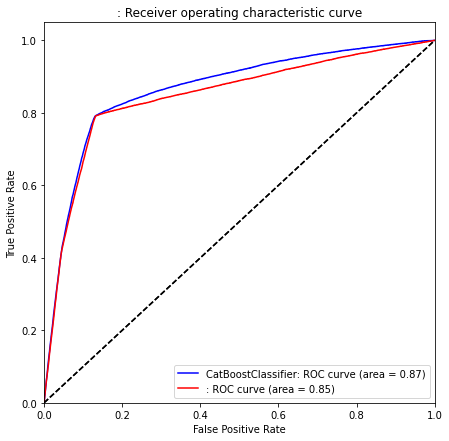

In [49]:
fpr, tpr, _ = roc_curve(y_valid_cat, cat_proba_1)
plt.figure(figsize=(7, 7))
plot_roc_curve(fpr, tpr, "CatBoostClassifier", color='b')
print("CatBoostClassifier: AUC_ROC = %.3f" % auc(fpr, tpr))

fpr, tpr, _ = roc_curve(y_valid, logreg_proba_1)
plot_roc_curve(fpr, tpr, "", color='r')
print("LogisticRegression: AUC_ROC = %.3f" % auc(fpr, tpr))

Catboost имеет чуть лучший показатель.

### Precision-Recall-кривая

CatBoostClassifier: AUC_PR = 0.355
LogisticRegression: AUC_PR = 0.343


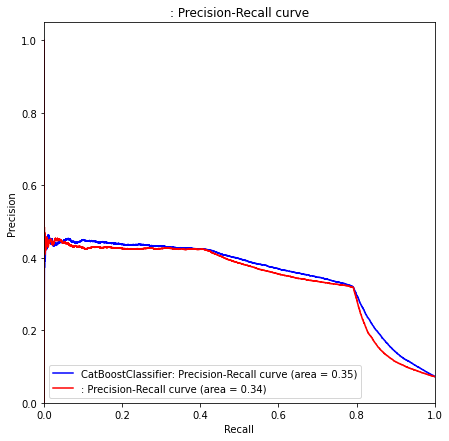

In [50]:
precision, recall, _ = precision_recall_curve(y_valid_cat, cat_proba_1)
plt.figure(figsize=(7, 7))    
plot_precision_recall_curve(precision, recall, "CatBoostClassifier", color='b')
print("CatBoostClassifier: AUC_PR = %.3f" % auc(recall, precision))

precision, recall, _ = precision_recall_curve(y_valid, logreg_proba_1) 
plot_precision_recall_curve(precision, recall, "", color='r')
print("LogisticRegression: AUC_PR = %.3f" % auc(recall, precision))

По графику видно, что значения точности выше ~0.4 достигнуть нельзя, но при этом почти не теряя точности можно добиться полноты до 0.8.

### Сonfusion matrix и практическое применение результата

In [51]:
print(confusion_matrix(y_valid,cat_pred))

[[221258  33369]
 [  4138  15681]]


Построим график аналогично логистической регрессии

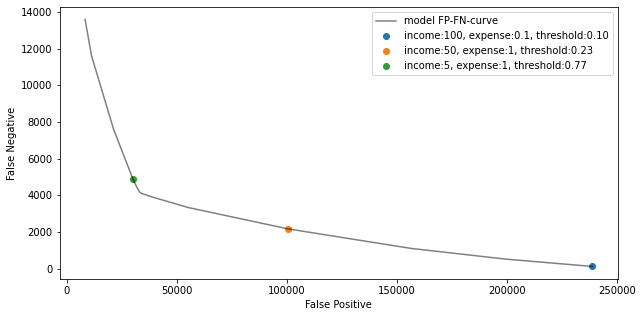

In [52]:
income_expense = [[100, 0.1],
                  [50, 1],
                  [5, 1]]

plot_fp_fn_curve(y_valid_cat, cat_proba_1, np.linspace(0.1,0.9,20), income_expense)

* доход 100 р., затраты 10 коп. - наиболее оптимальный порог для предсказаний с максимальной выгодой - 0.1
* доход 50 р., затраты 1 руб. - наиболее оптимальный порог для предсказаний с максимальной выгодой - 0.23
* доход 5 р., затраты 1 руб. - наиболее оптимальный порог для предсказаний с максимальной выгодой - 0.77

# 5 Финальная модель и предсказание на тестовых данных

### Предобработка и селекция полной тренирововчной выборки

In [53]:
selector = SelectPercentile()
X_cat_fin = selector.fit_transform(X[f_ok], y)
columns = X[f_ok].columns
support = selector.get_support()
selected_columns = columns[support]

for feat in f_categorical+f_weight:
    assert feat in selected_columns

X_cat_fin = pd.DataFrame(X_cat_fin, columns=selected_columns)

X_cat_fin[f_categorical] = X_cat_fin[f_categorical].astype('int').astype('category')

### Обучение финальной модели Catboost

In [54]:
fin_model = CatBoostClassifier(loss_function='Logloss',
                               random_seed = 42,
                               auto_class_weights='Balanced',
                               task_type='GPU',
                               logging_level='Silent',
                               cat_features=f_categorical,
                               od_type='IncToDec',
                               **best_cat_params)

In [55]:
fin_model.fit(X=X_cat_fin, y=y)

### сохранение финальной модели в pickle

In [56]:
import pickle
with open('/content/drive/My Drive/Colab Notebooks/megafon/final/final_model.pkl', 'wb') as file:
        pickle.dump(fin_model, file)

### Загрузка, предобработка и селекция тестовых данных

In [57]:
test_data = pd.read_pickle(test_path)

In [58]:
w_sc = StandardScaler().fit_transform(test_data['time_delta'].values.reshape(-1,1))
w = 1 / (1 + np.exp(w_sc))

assert not np.isnan(w).any()

test_data['time_delta'] = w

X_test = test_data.drop(['id','buy_time_vas'], axis=1)

X_test.loc[X_test['252']>1,:] = X_test['252'].value_counts().argmax()

X_cat_test = selector.transform(X_test[f_ok])

X_cat_test = pd.DataFrame(X_cat_test, columns=selected_columns)

X_cat_test[f_categorical] = X_cat_test[f_categorical].astype('int').astype('category')

### Предсказание на тестовых данных

In [59]:
test_pred_proba = fin_model.predict_proba(X_cat_test)[:,1]

### Формирование отчетного файла с предсказаниями и его сохранение в answers_test.csv

In [60]:
answers_test = test_data[['buy_time_vas', 'id', 'vas_id']].rename({'buy_time_vas': 'buy_time'}).copy()

In [61]:
answers_test['target'] = test_pred_proba

In [62]:
answers_test.head()

,buy_time_vas,id,vas_id,target
0,1.548018e+09,3130519.0,2.0,0.165960
1,1.548018e+09,2000860.0,4.0,0.769460
2,1.546808e+09,1099444.0,2.0,0.274899
3,1.547413e+09,1343255.0,5.0,0.198435
4,1.546808e+09,1277040.0,2.0,0.178392


In [63]:
answers_test.to_csv('/content/drive/My Drive/Colab Notebooks/megafon/final/answers_test.csv')